In [68]:
import numpy as np
import pandas as pd
import tqdm

In [69]:
from torchvision import datasets, transforms

#Define transformation
transform=transforms.ToTensor()

#Load the training dataset
train_dataset=datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

#Load test dataset seperately
test_dataset=datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

from torch.utils.data import random_split

# Define sizes for train and validation splits
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # 20% for validation

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [70]:
# Dataloader for mini-batch processing
import torch
# Create DataLoader for the training set
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)

# Create DataLoader for the validation set
valloader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)

# Test DataLoader (for independent test set)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [71]:
class DenseLayer:
    def __init__(self, input_dim, output_dim):
        # Initializing weights and biases
        self.weights = np.random.randn(input_dim, output_dim) * 0.01
        self.biases = np.zeros((1, output_dim))

    def forward(self, inputs, training=True):
        # Store inputs for use in backpropagation
        self.inputs = inputs
        # Linear transformation
        self.output = np.dot(inputs, self.weights) + self.biases
        return self.output

    def backward(self, d_out, learning_rate):
        # Gradient of weights and biases
        self.d_weights = np.dot(self.inputs.T, d_out)
        self.d_biases = np.sum(d_out, axis=0, keepdims=True)
        # Gradient of inputs
        self.d_inputs = np.dot(d_out, self.weights.T)
        # Update weights and biases
        self.weights -= learning_rate * self.d_weights
        self.biases -= learning_rate * self.d_biases
        return self.d_inputs

In [72]:
class BatchNormalization:
    def __init__(self, dim, epsilon=1e-5, momentum=0.9):
        self.epsilon = epsilon
        self.momentum = momentum
        self.gamma = np.ones((1, dim))
        self.beta = np.zeros((1, dim))
        self.running_mean = np.zeros((1, dim))
        self.running_var = np.ones((1, dim))

    def forward(self, inputs, training=True):
        self.inputs = inputs
        if training:
            # Calculate mean and variance for the batch
            self.batch_mean = np.mean(inputs, axis=0)
            self.batch_var = np.var(inputs, axis=0)

            # Normalize the batch
            self.normalized = (inputs - self.batch_mean) / np.sqrt(self.batch_var + self.epsilon)

            # Scale and shift
            self.output = self.gamma * self.normalized + self.beta

            # Update running statistics
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.batch_var
        else:
            # Use running mean and variance for inference
            self.normalized = (inputs - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
            self.output = self.gamma * self.normalized + self.beta
        return self.output

    def backward(self, d_out, learning_rate):
        # Gradient of beta and gamma
        self.d_beta = np.sum(d_out, axis=0)
        self.d_gamma = np.sum(d_out * self.normalized, axis=0)

        # Gradient of normalized input
        d_normalized = d_out * self.gamma

        # Gradient of variance
        d_var = np.sum(d_normalized * (self.inputs - self.batch_mean) * -0.5 * (self.batch_var + self.epsilon) ** (-1.5), axis=0)

        # Gradient of mean
        d_mean = np.sum(d_normalized * -1 / np.sqrt(self.batch_var + self.epsilon), axis=0) + d_var * np.mean(-2 * (self.inputs - self.batch_mean), axis=0)

        # Gradient of inputs
        d_inputs = d_normalized / np.sqrt(self.batch_var + self.epsilon) + d_var * 2 * (self.inputs - self.batch_mean) / d_out.shape[0] + d_mean / d_out.shape[0]

        # Update gamma and beta
        self.gamma -= learning_rate * self.d_gamma
        self.beta -= learning_rate * self.d_beta

        return d_inputs


In [73]:
class ReLU:
    def forward(self, inputs, training=True):
        self.inputs = inputs
        return np.maximum(0, inputs)

    def backward(self, d_out):
        d_out[self.inputs <= 0] = 0
        return d_out

In [74]:
class Softmax:
    def forward(self, inputs, training=True):
        # Ensure numerical stability with max subtraction
        exps = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exps / np.sum(exps, axis=1, keepdims=True)
        return self.output

In [75]:
class SimpleNN:
    def __init__(self, layers):
        self.layers = layers

    def forward(self, inputs, training=True):
        for layer in self.layers:
            if isinstance(layer, BatchNormalization):
                inputs = layer.forward(inputs, training)
            else:
                inputs = layer.forward(inputs)
        return inputs

    def backward(self, loss_grad, learning_rate):
        for layer in reversed(self.layers):
            # Pass learning_rate to DenseLayer and BatchNormalization layers
            if isinstance(layer, (DenseLayer, BatchNormalization)):
                loss_grad = layer.backward(loss_grad, learning_rate)
            else:
                loss_grad = layer.backward(loss_grad)

    # Method to extract weights
    def get_weights(self):
        weights = []
        for layer in self.layers:
            if hasattr(layer, 'biases'):
                weights.append((layer.weights, layer.biases))
            elif hasattr(layer, 'gamma'):
                weights.append((layer.gamma, layer.beta,layer.running_mean,layer.running_var))
        return weights

    # Method to set weights
    def set_weights(self, weights):
        idx = 0
        for layer in self.layers:
            if hasattr(layer, 'biases'):
                layer.weights, layer.biases = weights[idx]
                idx += 1
            elif hasattr(layer, 'gamma'):
                layer.gamma, layer.beta, layer.running_mean, layer.running_var = weights[idx]
                idx += 1

In [76]:
class Dropout:
    def __init__(self, rate):
        self.rate = rate

    def forward(self, inputs, training=True):
        if training:
            self.mask = (np.random.rand(*inputs.shape) > self.rate) / (1 - self.rate)
            return inputs * self.mask
        return inputs

    def backward(self, d_out):
        return d_out * self.mask

In [77]:
class AdamOptimizer:
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m_t = 0
        self.v_t = 0
        self.t = 0

    def update(self, weights, d_weights):
        self.t += 1
        self.m_t = self.beta1 * self.m_t + (1 - self.beta1) * d_weights
        self.v_t = self.beta2 * self.v_t + (1 - self.beta2) * (d_weights ** 2)
        m_hat = self.m_t / (1 - self.beta1 ** self.t)
        v_hat = self.v_t / (1 - self.beta2 ** self.t)
        weights -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return weights


In [78]:
def cross_entropy_loss(predictions, labels):
    # Ensure numerical stability with log-sum-exp trick
    exps = np.exp(predictions - np.max(predictions, axis=1, keepdims=True))
    softmax = exps / np.sum(exps, axis=1, keepdims=True)
    # Loss calculation
    loss = -np.sum(labels * np.log(softmax + 1e-8)) / predictions.shape[0]
    return loss, softmax

def accuracy(preds, labels):
    return np.mean(preds == labels)

In [79]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def evaluate(model, loader):
    #model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.view(inputs.shape[0], -1).numpy()
            labels_onehot = np.eye(10)[labels.numpy()]

            # Forward pass
            outputs = model.forward(inputs, training=False)
            loss, softmax_outputs = cross_entropy_loss(outputs, labels_onehot)
            total_loss += loss

            # Calculate accuracy
            predictions = np.argmax(softmax_outputs, axis=1)
            correct_predictions += np.sum(predictions == labels.numpy())
            total_samples += labels.shape[0]

            # Store labels and predictions for F1 calculation
            all_labels.extend(labels.numpy())
            all_predictions.extend(predictions)

    # Calculate average loss, accuracy, and macro-F1 score
    avg_loss = total_loss / len(loader)
    accuracy = correct_predictions / total_samples
    f1 = f1_score(all_labels, all_predictions, average='macro')
    return avg_loss, accuracy, f1

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, val_macro_f1_scores):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(14, 5))

    # Plot training and validation loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs. Epochs")
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Epochs")
    plt.legend()

    # Plot validation macro-F1 scores
    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_macro_f1_scores, label="Validation Macro-F1")
    plt.xlabel("Epochs")
    plt.ylabel("Macro-F1 Score")
    plt.title("Macro-F1 Score vs. Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [80]:

def train(model, trainloader, valloader, optimizer, epochs=10, learning_rate=0.001):
    # Lists to store metrics for reporting
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    val_macro_f1_scores = []

    for epoch in range(epochs):
        # Training phase
        #model.train()  # Set model to training mode
        epoch_loss = 0
        correct_predictions = 0
        total_samples = 0

        for batch in tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            inputs, labels = batch
            inputs = inputs.view(inputs.shape[0], -1).numpy()  # Flatten 28x28 images
            labels_onehot = np.eye(10)[labels.numpy()]  # One-hot encoding for labels

            # Forward pass
            outputs = model.forward(inputs)
            loss, softmax_outputs = cross_entropy_loss(outputs, labels_onehot)
            epoch_loss += loss

            # Calculate accuracy
            predictions = np.argmax(softmax_outputs, axis=1)
            correct_predictions += np.sum(predictions == labels.numpy())
            total_samples += labels.shape[0]

            # Backward pass
            loss_grad = softmax_outputs - labels_onehot
            model.backward(loss_grad, learning_rate)

        # Calculate average training loss and accuracy
        train_losses.append(epoch_loss / len(trainloader))
        train_accuracies.append(correct_predictions / total_samples)

        # Validation phase
        val_loss, val_accuracy, val_f1 = evaluate(model, valloader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_macro_f1_scores.append(val_f1)

        # Print epoch summary
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracies[-1]:.4f}")
        print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}, Validation Macro-F1: {val_macro_f1_scores[-1]:.4f}")

    # Plotting metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, val_macro_f1_scores)

In [81]:
#from sklearn.metrics import accuracy_score, f1_score
#def evaluate(model, testloader):
 #   correct_predictions = 0
  #  total_samples = 0
   # all_preds = []
    #all_labels = []

    #for batch in testloader:
     #   inputs, labels = batch
      #  inputs = inputs.view(inputs.shape[0], -1).numpy()
       # labels = labels.numpy()

        #outputs = model.forward(inputs)
        #predictions = np.argmax(outputs, axis=1)

       # all_preds.extend(predictions)
        #all_labels.extend(labels)
        #correct_predictions += np.sum(predictions == labels)
        #total_samples += labels.shape[0]

    #accuracy = correct_predictions / total_samples
    #f1 = f1_score(all_labels, all_preds, average='macro')
    #print(f"Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")


Epoch 1/10 - Training:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1/10 - Training: 100%|██████████| 750/750 [00:05<00:00, 125.13it/s]


Epoch 1/10
Training Loss: 0.5387, Training Accuracy: 0.8062
Validation Loss: 0.4276, Validation Accuracy: 0.8433, Validation Macro-F1: 0.8403


Epoch 2/10 - Training: 100%|██████████| 750/750 [00:05<00:00, 127.78it/s]


Epoch 2/10
Training Loss: 0.4102, Training Accuracy: 0.8514
Validation Loss: 0.4239, Validation Accuracy: 0.8389, Validation Macro-F1: 0.8366


Epoch 3/10 - Training: 100%|██████████| 750/750 [00:05<00:00, 125.77it/s]


Epoch 3/10
Training Loss: 0.3686, Training Accuracy: 0.8644
Validation Loss: 0.3800, Validation Accuracy: 0.8612, Validation Macro-F1: 0.8584


Epoch 4/10 - Training: 100%|██████████| 750/750 [00:06<00:00, 122.77it/s]


Epoch 4/10
Training Loss: 0.3490, Training Accuracy: 0.8710
Validation Loss: 0.3841, Validation Accuracy: 0.8610, Validation Macro-F1: 0.8574


Epoch 5/10 - Training: 100%|██████████| 750/750 [00:06<00:00, 124.85it/s]


Epoch 5/10
Training Loss: 0.3312, Training Accuracy: 0.8779
Validation Loss: 0.3630, Validation Accuracy: 0.8695, Validation Macro-F1: 0.8668


Epoch 6/10 - Training: 100%|██████████| 750/750 [00:06<00:00, 124.06it/s]


Epoch 6/10
Training Loss: 0.3162, Training Accuracy: 0.8834
Validation Loss: 0.3898, Validation Accuracy: 0.8578, Validation Macro-F1: 0.8546


Epoch 7/10 - Training: 100%|██████████| 750/750 [00:06<00:00, 115.75it/s]


Epoch 7/10
Training Loss: 0.3060, Training Accuracy: 0.8870
Validation Loss: 0.3941, Validation Accuracy: 0.8548, Validation Macro-F1: 0.8549


Epoch 8/10 - Training: 100%|██████████| 750/750 [00:06<00:00, 110.35it/s]


Epoch 8/10
Training Loss: 0.2925, Training Accuracy: 0.8914
Validation Loss: 0.3716, Validation Accuracy: 0.8619, Validation Macro-F1: 0.8630


Epoch 9/10 - Training: 100%|██████████| 750/750 [00:05<00:00, 127.79it/s]


Epoch 9/10
Training Loss: 0.2863, Training Accuracy: 0.8931
Validation Loss: 0.3388, Validation Accuracy: 0.8785, Validation Macro-F1: 0.8770


Epoch 10/10 - Training: 100%|██████████| 750/750 [00:05<00:00, 125.13it/s]


Epoch 10/10
Training Loss: 0.2778, Training Accuracy: 0.8974
Validation Loss: 0.3456, Validation Accuracy: 0.8769, Validation Macro-F1: 0.8757


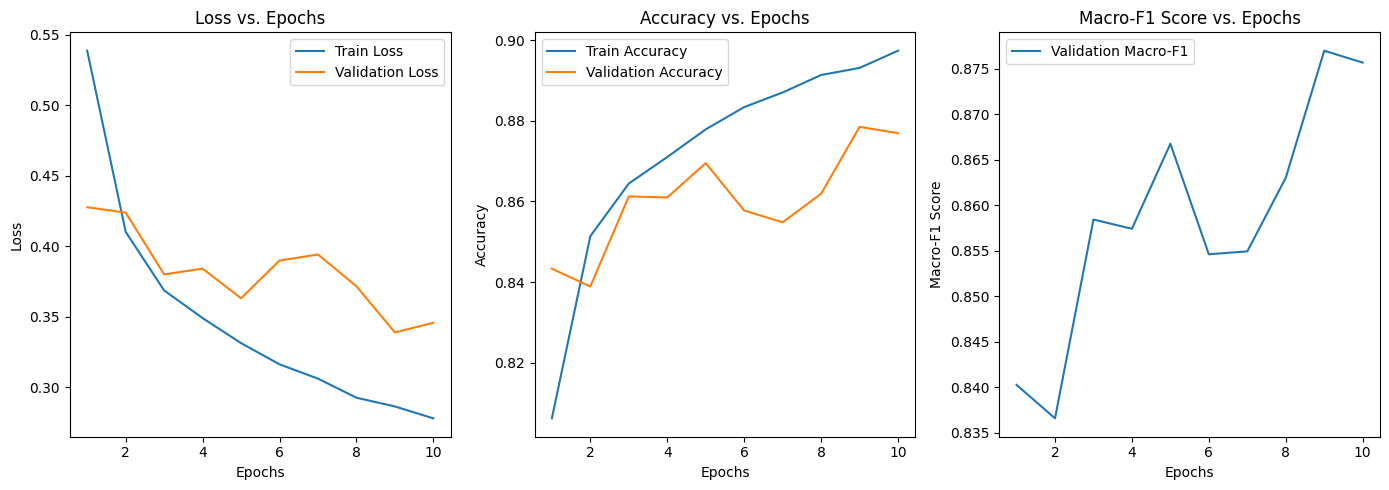

Test avg loss, accuracy, f1 score:


(0.3654525785615363, 0.8717, 0.8708474847967338)

In [82]:
# Define the model architecture
input_dim = 28 * 28  # FashionMNIST images are 28x28
output_dim = 10      # 10 classes

# Set up model layers
layers = [
    DenseLayer(input_dim, 128),
    BatchNormalization(128),
    ReLU(),
    Dropout(rate=0.2),
    DenseLayer(128, 64),
    BatchNormalization(64),
    ReLU(),
    DenseLayer(64, output_dim),
    #Softmax()
]

# Create the model and optimizer
model = SimpleNN(layers)
optimizer = AdamOptimizer(learning_rate=0.003)

# Train and evaluate
train(model, trainloader, valloader, optimizer, epochs=10, learning_rate=0.003)
print("Test avg loss, accuracy, f1 score:")
evaluate(model, testloader)


In [83]:
import pickle
# Save only weights
weights = model.get_weights()
with open('model_1905103.pickle', 'wb') as file:
    pickle.dump(weights, file)

In [84]:
# Define the model architecture
input_dim = 28 * 28  # FashionMNIST images are 28x28
output_dim = 10      # 10 classes

# Set up model layers
layers = [
    DenseLayer(input_dim, 128),
    BatchNormalization(128),
    ReLU(),
    Dropout(rate=0.2),
    DenseLayer(128, 64),
    BatchNormalization(64),
    ReLU(),
    DenseLayer(64, output_dim),
    #Softmax()
]
model = SimpleNN(layers)  # Use the same layers structure as during training

# Load weights
with open('model_1905103.pickle', 'rb') as file:
    weights = pickle.load(file)
model.set_weights(weights)

#predictions = model.forward(testloader, training=False)
print("Test avg loss, accuracy, f1 score:")
evaluate(model, testloader)
#predicted_labels = np.argmax(predictions, axis=1)


Test avg loss, accuracy, f1 score:


(0.36720520698835873, 0.8695, 0.8687057430589501)